<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Kaggle-Challenge/blob/main/guidedProject_Unit2_Sprint_2_module3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Validation

* Do **k-fold cross-validation** with independent test set
* Use scikit-learn for **hyperparameter optimization**

In [1]:
import sys
# If you're on Colab:
if 'google.colab' in sys.modules:
  DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
  !pip install category_encoders==2.*
else:
  DATA_PATH = '../data/'

     |████████████████████████████████| 80 kB 4.1 MB/s 


In [4]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score #k-fold cross validation,
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # hyperparameter fine tuning 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

# I. Wrangle Data

In [5]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, na_values=[0, -2.000000e-08],parse_dates=['date_recorded']), pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], parse_dates=['date_recorded'], index_col='id')
  # drop constant columns 
  df.drop(columns=['recorded_by'], inplace=True)
  # create age feature 
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns=['date_recorded'], inplace=True)
  # drop high cardinality columns 
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 100]
  df.drop(columns = drop_cols, inplace=True)
  # drop duplicate columns 
  dup_cols = [col for col in df.head(15).T.duplicated().index if df.head(15).T.duplicated()[col]]
  df.drop(columns=dup_cols, inplace=True)
  return df

In [7]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv', DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

#II. Split Data

# Split TV from FM

In [8]:
target = 'status_group'
y_train = df[target]
X_train = df.drop(columns=target)

# Training-Validation Split

* Since we're doing k-fold CV (cross validation), there's no need for a validation set

# III. Establish Baseline

This is a **classification** our baseline with be **accuracy**

In [9]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430899510092763


# IV. Build Models

* DecisionTreeClassifier
* RandomForestClassifier

In [10]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

In [11]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, random_state=42)
)

**Check cross-validation scores**

In [19]:
cv_scores_dt = cross_val_score(model_dt, X_train, y_train, cv=5, n_jobs=-1)
cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, n_jobs=-1)

In [20]:
print('CV score DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV score DecisionTreeClassifier
[0.75782828 0.74991582 0.75917508 0.75580808 0.74779022]
Mean CV accuracy score: 0.7541034981518187
STD CV accuracy score: 0.0044697812186829024


In [21]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.80505051 0.79907407 0.79991582 0.79974747 0.79425878]
Mean CV accuracy score: 0.7996093309558248
STD CV accuracy score: 0.003424451376257444


# V. Tune Model

* What are important hyperparameters for RandomForestClassifier?
  * max_depth: 5-35
  * n_estimators: 25-100
  * imputation strategy: mean or median

**GridSearch**: Very thourough, but it can take a long time

In [26]:
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5, 40, 5),
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}

model_rfgs = GridSearchCV(
    model_rf, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)



In [27]:
model_rfgs.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 20.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [22]:
7*4*2*5 #number of models for grid search

280

In [28]:
type(model_rfgs) # type is GridSearchCV but can predict similar to a model

sklearn.model_selection._search.GridSearchCV

In [30]:
model_rfgs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [33]:
model_rfgs.best_estimator_

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                   

In [32]:
model_rfgs.best_score_

0.8081954290498781

**RandomizedSearchCV**: Quicker, less effective but usually good enough

In [34]:
param_distribution = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5, 40, 5),
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}

model_rfrs = RandomizedSearchCV(
    model_rf,
    param_distributions=param_distribution,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [36]:
model_rfrs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [37]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [38]:
model_rfrs.best_score_

0.8081954290498781

# Make Submission

In [39]:
# make a dataframe with an index column of id and a column with status_group
y_pred = model_rfgs.predict(X_test)

In [40]:
type(y_pred)

numpy.ndarray

In [41]:
y_pred.shape

(14358,)

In [43]:
y_pred[:10]

array(['functional', 'functional', 'functional', 'non functional',
       'functional', 'functional', 'functional', 'non functional',
       'non functional', 'functional'], dtype=object)

In [48]:
# pd.DataFrame(y_pred, index=X_test.index, columns=['status_group']).head()
submission = pd.DataFrame({'status_group': y_pred}, index=X_test.index).head()

In [59]:
date_stamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M') # year-month-day_hour-min hour in 24 format

In [60]:
#convert to dataframe to csv 
submission.to_csv(f'{date_stamp}submisison.csv')

# VI. Communicate Results

**Showing Feature Importance**

Plot the feature importance for our RandomForest model

In [68]:
bestimator = model_rfgs.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns

feature_impt = pd.Series(importances, index=features).sort_values()

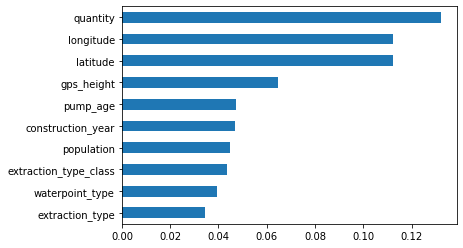

In [70]:
feature_impt.tail(10).plot(kind='barh');